# exp001
まずはgroupで完結した形でモデリング

In [32]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import polars as pl
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import cudf
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from noglobal import noglobal


In [33]:
@dataclass
class Cfg:
    exp_name = "exp001"
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")
    seed = 42
    n_splits = 5
cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

In [34]:
@noglobal(excepts=["cfg", "logger"])
def transform_labels_df(labels):
    """
    labelsデータを整形する
    """

    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=12), "level_group"] = "5-12"
    labels.loc[labels["question"]>=13, "level_group"] = "13-22"

    return labels

In [35]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions):
        self.sessions = sessions.copy()
        self.features = sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _lg_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_event_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in add_features["event_name"].unique():
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            tmp = tmp.rename(columns={"cnt": f"lg_{event}_record_cnt"})
            self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")

    def _lg_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in add_features["name"].unique():
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            tmp = tmp.rename(columns={"cnt": f"lg_{name}_record_cnt"})
            self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")

    def _lg_elapsed_time(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["lg_elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "lg_elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_coor_mean(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"lg_room_coor_x_mean", "room_coor_y":"lg_room_coor_y_mean", "screen_coor_x":"lg_screen_coor_x_mean", "screen_coor_y":"lg_screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def get_features(self):
        self._lg_record_cnt()
        self._lg_event_name_record_cnt()
        self._lg_name_record_cnt()
        self._lg_elapsed_time()
        self._lg_coor_mean()
        return self.features

In [36]:
@noglobal(excepts=["cfg", "logger"])
def get_train_data(sessions, labels):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")

    return train

# 学習・評価

In [37]:
# データ読み込み
train_sessions = pd.read_csv(cfg.input_dir + "train.csv")
labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
test = pd.read_csv(cfg.input_dir + "test.csv")
sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")

In [38]:
train = get_train_data(train_sessions, labels)

In [39]:
target = "correct"
not_use_cols = [target]
features = [c for c in train.columns if c not in not_use_cols]

params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed,
}

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3831
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.49107	valid_1's binary_logloss: 0.501052
[200]	training's binary_logloss: 0.477319	valid_1's binary_logloss: 0.501128
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.482953	valid_1's binary_logloss: 0.500764


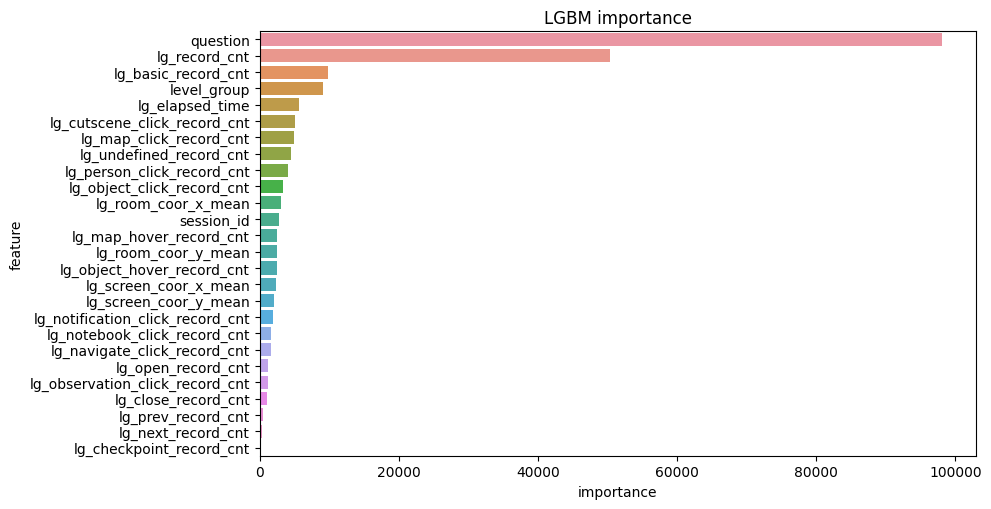

In [40]:
gkf = GroupKFold(n_splits=cfg.n_splits)
for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
    tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
    vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    break

# 特徴量重要度
fi = pd.DataFrame()
fi["feature"] = model.feature_name()
fi["importance"] = model.feature_importance(importance_type="gain")
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

# モデル出力
model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model.lgb")
